In [1]:
import sys
from netCDF4 import Dataset
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
from trackeddy.plotfunc import *
from numpy import *
from pylab import *
import cmocean as cm
import random
%matplotlib inline
import scipy.optimize as opt

In [2]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def moveGaussian(size,fwhm,center,timestep):
    z=zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

In [3]:
from random import randrange, uniform

def moveGaussian(size,fwhm,center,timestep):
    z=zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

def RandGaussian(size,time,nn):
    zz=zeros([time,size,size])
    zz1=zz*1
    ii=0
    while ii < nn:
        xx=(randrange(0, 100)/100.0)*size
        xxx=(randrange(0, 100)/100.0)*size
        yyy=(randrange(0, 100)/100.0)*size
        if xx > size/8 and xx < size/4:
            center=array([[xxx,yyy+x] for x in linspace(size*0.1,size*0.9,time)])
            #print(center)
            for tt in range(0,time):
                zz1[tt,:,:]=makeGaussian(size, xx,(center[tt,0],center[tt,1]))
            zz=zz+zz1
            ii=ii+1
    return zz

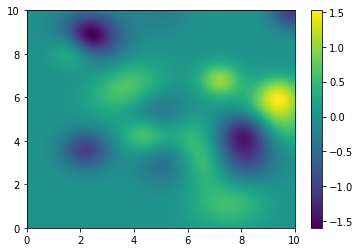

In [4]:
size=600
time=40
zzn=-RandGaussian(size,time,10)
zzp=RandGaussian(size,time,10)

zz=zzn+zzp

lat=linspace(0,10,600)
lon=linspace(0,10,600)

pcolormesh(lon,lat,zz[0,:,:])
colorbar()

In [5]:
eddytdp=analyseddyzt(zz[:,:,:],lon,lat,0,40,1,zz.max(),0.1,0.05,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

 0% [=======================================>]100% Time Elapsed: 194 s  Number of contours analysed: 87 


In [6]:
eddytdn=analyseddyzt(zz[:,:,:],lon,lat,0,40,1,zz.min(),-0.1,-0.05,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

 0% [=======================================>]100% Time Elapsed: 241 s  Number of contours analysed: 162 


[0.48410315 0.44004855 0.51557147 0.         0.         0.        ]


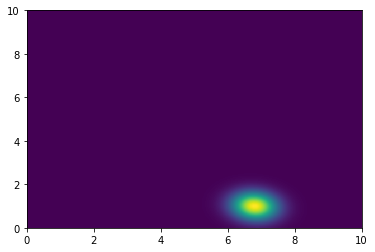

In [7]:
Lon,Lat=meshgrid(lon,lat)
gaussfit=eddytdp['eddyn_1']['2dgaussianfit'][0]
maxvalue0=eddytdp['eddyn_1']['position_maxvalue'][0][0]
maxvalue1=eddytdp['eddyn_1']['position_maxvalue'][0][1]
maxvalue2=eddytdp['eddyn_1']['position_maxvalue'][0][2]
print(gaussfit)
gaussian=twoD_Gaussian((Lon,Lat,maxvalue0,maxvalue1,maxvalue2), *gaussfit)
pcolormesh(lon,lat,gaussian.reshape(600,600))

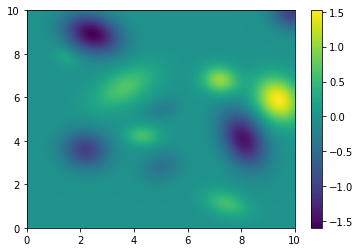

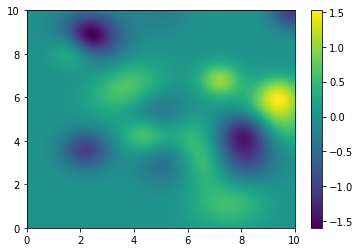

In [8]:
sfield=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
nfield=reconstruct_syntetic(shape(zz),lon,lat,eddytdn)
pcolormesh(lon,lat,sfield[0,:,:]+nfield[0,:,:])
colorbar()
figure()
pcolormesh(lon,lat,zz[0,:,:])
colorbar()

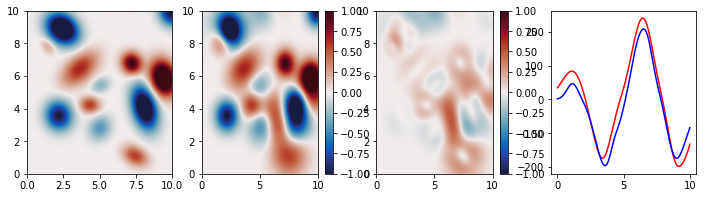

In [9]:
rtext=[]
for ii in range(0,40):
    rtext.append(rsquard(sum(zz[ii,:,:],axis=1),sum(sfield[ii,:,:]+nfield[0,:,:],axis=1)))

fig = plt.figure(figsize=(12, 3),facecolor='white')
gs = gridspec.GridSpec(1, 4)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon,lat,sfield[0,:,:]+nfield[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon,lat,zz[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon,lat,zz[0,:,:]-sfield[0,:,:]-nfield[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb3 = fig.colorbar(quad3,ax=ax3)

ax4=plt.subplot(gs[0,3])

line4a, =ax4.plot(lat,sum(zz[0,:,:],axis=1),'-r')
line4b, =ax4.plot(lat,sum(sfield[0,:,:]+nfield[0,:,:],axis=1),'-b')
text4 = ax4.text(mean(lat),100,'')
#ax4.set_ylim([-150,150])
show()

In [10]:
from scipy.spatial import distance
XA=eddytdp['eddyn_1']['contour'][0]
XB=eddytdp['eddyn_1']['ellipse'][0]
distance.cdist(XA, XB, 'euclidean')

array([[11.75738126,  9.99289964],
       [21.54505745, 10.87783427]])

In [11]:
print(shape(XA))
print(shape(XB))

(2, 357)
(2, 357)


In [12]:
def ssh2ke():
    pass

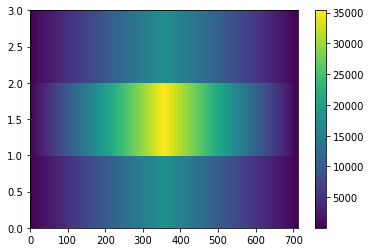

In [13]:
from scipy.signal import correlate2d
plt.pcolormesh(correlate2d(XA,XB))
colorbar()

In [14]:
XA,XB

([array([7.16193656, 7.17863105, 7.19532554, 7.21202003, 7.22871452,
         7.24540902, 7.26210351, 7.278798  , 7.29549249, 7.31218698,
         7.32888147, 7.34557596, 7.36227045, 7.37391325, 7.37896494,
         7.39565943, 7.41235392, 7.42904841, 7.4457429 , 7.4624374 ,
         7.47163993, 7.47913189, 7.49582638, 7.51252087, 7.52921536,
         7.53757524, 7.54590985, 7.56260434, 7.57929883, 7.59083909,
         7.59599332, 7.61268781, 7.6293823 , 7.63658439, 7.64607679,
         7.66277129, 7.67709716, 7.67946578, 7.69616027, 7.71285476,
         7.7136324 , 7.72954925, 7.74624374, 7.74696326, 7.76293823,
         7.7775971 , 7.77963272, 7.79632721, 7.80588473, 7.8130217 ,
         7.82971619, 7.83193109, 7.84641068, 7.85609159, 7.86310518,
         7.8782489 , 7.87979967, 7.89649416, 7.89870638, 7.91318865,
         7.91746023, 7.92988314, 7.93449638, 7.94657763, 7.94986255,
         7.96327212, 7.96357115, 7.97595061, 7.97996661, 7.98679683,
         7.99606849, 7.9966611 , 8

In [15]:
corrcoef(XA,XB)

array([[ 1.        , -0.05656619,  0.32678018,  0.91308782],
       [-0.05656619,  1.        , -0.96147943,  0.35400842],
       [ 0.32678018, -0.96147943,  1.        , -0.08503608],
       [ 0.91308782,  0.35400842, -0.08503608,  1.        ]])